In [9]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import xarray as xr


In [13]:
tmpk_700 = tmpk_700.metpy.quantify()
tmpk_300 = tmpk_300.metpy.quantify()

In [16]:
ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/'
                     'casestudies/python-gallery/NARR_19930313_1800.nc').metpy.parse_cf()

# Get lat/lon data from file
lats = ds.lat.data
lons = ds.lon.data

# Calculate variable dx, dy values for use in calculations
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# Get 700-hPa data and smooth
level = 700 * units.hPa
hght_700 = mpcalc.smooth_n_point(ds['Geopotential_height_isobaric'].metpy.sel(
    vertical=level).squeeze(), 9)
tmpk_700 = mpcalc.smooth_n_point(ds['Temperature_isobaric'].metpy.sel(
    vertical=level).squeeze(), 9)
uwnd_700 = mpcalc.smooth_n_point(
    ds['u-component_of_wind_isobaric'].metpy.sel(vertical=level).squeeze(), 9)
vwnd_700 = mpcalc.smooth_n_point(
    ds['v-component_of_wind_isobaric'].metpy.sel(vertical=level).squeeze(), 9)

# Get 300-hPa data and
level = 300 * units.hPa
hght_300 = mpcalc.smooth_n_point(ds['Geopotential_height_isobaric'].metpy.sel(
    vertical=level).squeeze(), 9)
tmpk_300 = mpcalc.smooth_n_point(ds['Temperature_isobaric'].metpy.sel(
    vertical=level).squeeze(), 9)
uwnd_300 = mpcalc.smooth_n_point(
    ds['u-component_of_wind_isobaric'].metpy.sel(vertical=level).squeeze(), 9)
vwnd_300 = mpcalc.smooth_n_point(
    ds['v-component_of_wind_isobaric'].metpy.sel(vertical=level).squeeze(), 9)

# Convert Temperatures to degC
tmpc_700 = tmpk_700.to('degC')
tmpc_300 = tmpk_300.to('degC')

# Get time in a nice datetime object format
vtime = ds.time.values.astype('datetime64[ms]').astype('O')[0]

AttributeError: 'DataArray' object has no attribute 'to'

In [15]:
# Use MetPy advection function to calculate temperature advection at two levels
tadv_700 = mpcalc.advection(tmpk_700, (uwnd_700, vwnd_700),
                            (dx, dy), dim_order='yx').to_base_units()
tadv_300 = mpcalc.advection(tmpk_300, (uwnd_300, vwnd_300),
                            (dx, dy), dim_order='yx').to_base_units()

# Centered finite difference to calculate differential temperature advection
diff_tadv = ((tadv_700 - tadv_300)/(400 * units.hPa)).to_base_units()
Make Four Panel Plot

SyntaxError: invalid syntax (2753835006.py, line 9)

NameError: name 'tmpc_700' is not defined

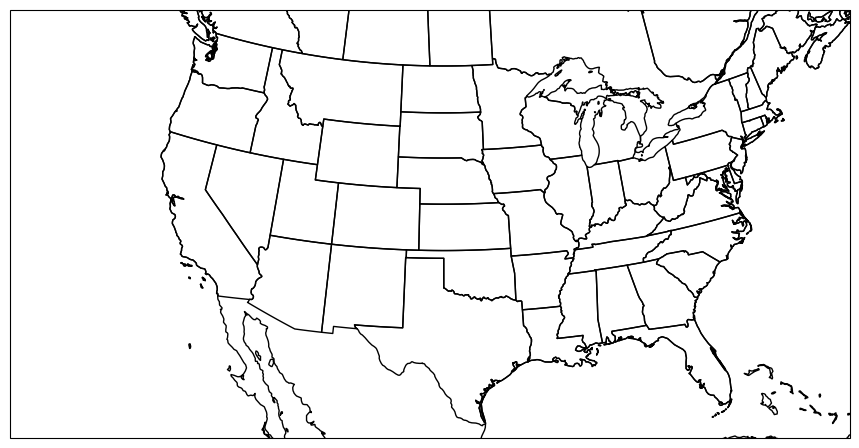

In [12]:
# Set up plot crs (mapcrs) and the data crs, will need to transform all variables
mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35,
                               standard_parallels=(30, 60))
datacrs = ccrs.PlateCarree()

# Set some common contour interval levels
clevs_700_tmpc = np.arange(-40, 41, 2)
clevs_700_hght = np.arange(0, 8000, 30)
clevs_300_hght = np.arange(0, 10000, 120)

# Create slice to reduce number of wind barbs at plot time
wind_slice = (slice(None, None, 10), slice(None, None, 10))

# Start figure
fig = plt.figure(1, figsize=(22, 15))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1, 1], hspace=0.03, wspace=0.03)

# Upper-left panel (700-hPa TMPC)
ax1 = plt.subplot(gs[0, 0], projection=mapcrs)
ax1.set_extent([-130, -72, 25, 49], ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeature.STATES.with_scale('50m'))

cf = ax1.contourf(lons, lats, tmpc_700, clevs_700_tmpc,
                  cmap=plt.cm.coolwarm, transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)
cb.set_label(r'$^{\circ}$C')

csf = ax1.contour(lons, lats, tmpc_700, clevs_700_tmpc, colors='grey',
                  linestyles='dashed', transform=datacrs)
plt.clabel(csf, fmt='%d')

cs = ax1.contour(lons, lats, hght_700, clevs_700_hght, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

ax1.barbs(lons[wind_slice], lats[wind_slice],
          uwnd_700.to('kt')[wind_slice].m, vwnd_700[wind_slice].to('kt').m,
          pivot='middle', color='black', transform=datacrs)

plt.title('700-hPa NARR HGHT (m), TMPC, and Wind (kt)', loc='left')
plt.title('Valid: {}'.format(vtime), loc='right')

# Lower-left panel (300-hPa TMPC)
ax2 = plt.subplot(gs[1, 0], projection=mapcrs)
ax2.set_extent([-130, -72, 25, 49], ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax2.add_feature(cfeature.STATES.with_scale('50m'))

cf = ax2.contourf(lons, lats, tmpc_300, range(-60, -24, 2),
                  cmap=plt.cm.BuPu_r, transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)
cb.set_label(r'$^{\circ}$C')

csf = ax2.contour(lons, lats, tmpc_300, range(-60, 0, 2),
                  colors='grey', linestyles='dashed', transform=datacrs)
plt.clabel(csf, fmt='%d')

cs = ax2.contour(lons, lats, hght_300, clevs_300_hght, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

ax2.barbs(lons[wind_slice], lats[wind_slice],
          uwnd_300.to('kt')[wind_slice].m, vwnd_300[wind_slice].to('kt').m,
          pivot='middle', color='black', transform=datacrs)

plt.title('300-hPa NARR HGHT (m), TMPC, and Wind (kt)', loc='left')
plt.title('Valid: {}'.format(vtime), loc='right')

# Upper-right panel (700-hPa TMPC Adv)
ax3 = plt.subplot(gs[0, 1], projection=mapcrs)
ax3.set_extent([-130, -72, 25, 49], ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax3.add_feature(cfeature.STATES.with_scale('50m'))

cf = ax3.contourf(lons, lats, tadv_700*3600, range(-8, 9, 1),
                  cmap=plt.cm.coolwarm, transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)
cb.set_label(r'TMPC ADV ($^{\circ}$C h$^{-1}$)')

csf = ax3.contour(lons, lats, tmpc_700, clevs_700_tmpc, colors='grey',
                  linestyles='dashed', transform=datacrs)
plt.clabel(csf, fmt='%d')

cs = ax3.contour(lons, lats, hght_700, clevs_700_hght, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

ax3.barbs(lons[wind_slice], lats[wind_slice],
          uwnd_700.to('kt')[wind_slice].m, vwnd_700[wind_slice].to('kt').m,
          pivot='middle', color='black', transform=datacrs)

plt.title('700-hPa NARR HGHT (m), TMPC, and Wind (kt)', loc='left')
plt.title('Valid: {}'.format(vtime), loc='right')

# Lower-right panel (diff TMPC)
ax4 = plt.subplot(gs[1, 1], projection=mapcrs)
ax4.set_extent([-130, -72, 25, 49], ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax4.add_feature(cfeature.STATES.with_scale('50m'))

cf = ax4.contourf(lons, lats, diff_tadv*1e9, clevs_700_tmpc,
                  cmap=plt.cm.coolwarm, extend='both', transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, extendrect=True)
cb.set_label(r'dTMPC ($10^9$ $^{\circ}$C s$^{-1}$ Pa$^{-1}$)')

csf = ax4.contour(lons, lats, tmpc_700, clevs_700_tmpc, colors='grey',
                  linestyles='dashed', transform=datacrs)
plt.clabel(csf, fmt='%d')

cs = ax4.contour(lons, lats, hght_700, clevs_700_hght, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

ax4.barbs(lons[wind_slice], lats[wind_slice],
          uwnd_700.to('kt')[wind_slice].m, vwnd_700[wind_slice].to('kt').m,
          pivot='middle', color='black', transform=datacrs)

plt.title('700-hPa NARR HGHT (m), TMPC, and Wind (kt)', loc='left')
plt.title('Valid: {}'.format(vtime), loc='right')

plt.show()